# Model Algebra

## Setup

In [1]:
%matplotlib inline
import numpy as np
from tramp.base import (
    SISOVariable as V, SIMOVariable, MISOVariable, SILeafVariable, MILeafVariable
)
from tramp.priors import (
    GaussianPrior as GP, BinaryPrior as BP, GaussBernouilliPrior as GBP,
    MAP_L21NormPrior as L21
)
from tramp.likelihoods import (
    GaussianLikelihood as GL, AbsLikelihood as AbsL, SngLikelihood as SngL,
    ModulusLikelihood as ML
)
from tramp.channels import (
    GaussianChannel as GC, 
    AbsChannel as AbsC, SngChannel as SngC, ReluChannel as RC,
    LinearChannel as LC, GradientChannel as GradC, Blur1DChannel as BlurC,
    DuplicateChannel as DC, ConcatChannel as CC, SumChannel as SumC
)
import logging
logger = logging.getLogger()

In [2]:
# fake data
N = 10
shape = (N,)
y = np.ones(N)
W = np.ones((N,N))

## GLM

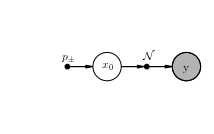

In [3]:
denoiser = BP(size=N) @ GL(y)
denoiser.to_factor_dag().to_model_dag().daft()

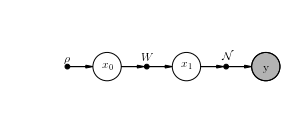

In [4]:
sparse_reg = GBP(size=N) @ LC(W) @ GL(y)
sparse_reg.to_factor_dag().to_model_dag().daft()

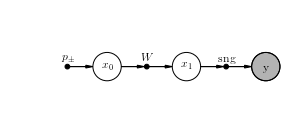

In [5]:
perceptron = BP(size=N) @ LC(W) @ SngL(y)
perceptron.to_factor_dag().to_model_dag().daft()

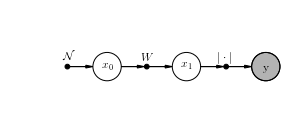

In [6]:
phase_retrieval = GP(size=N) @ LC(W) @ ML(y)
phase_retrieval.to_factor_dag().to_model_dag().daft()

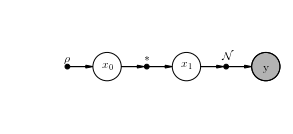

In [7]:
sparse_deconv = GBP(size=N) @ BlurC(N=N,sigma=1) @ GL(y)
sparse_deconv.to_factor_dag().to_model_dag().daft()

## Prior information on gradient

In [8]:
# variables
x = SIMOVariable(id="x", n_next=2)
x_prime = MILeafVariable(id="x'", n_prev=2)
# regression
reg = LC(W) @ V(id="z") @ GL(y)
# classification
clf = LC(W) @ V(id="z") @ GC() @ V(id="a") @ SngL(y)
# sparse gradient
sparse_grad =  (GradC(shape) + GBP(size=N)) @ x_prime
# total variation
tv =  (GradC(shape) + L21(size=N,scale=1)) @ x_prime

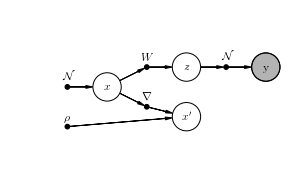

In [9]:
sparse_grad_regression = GP(size=N) @ x @ (reg + sparse_grad)
sparse_grad_regression.to_model_dag().daft()

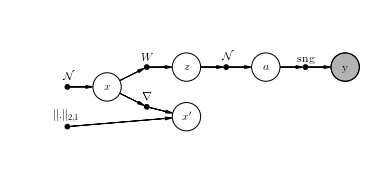

In [10]:
tv_classification = GP(size=N) @ x @ (clf + tv)
tv_classification.to_model_dag().daft()

## Committee

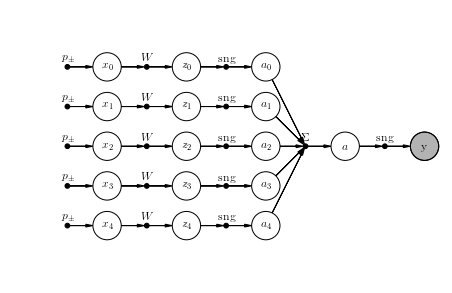

In [11]:
K = 5
experts = None
for k in range(K):
    expert = BP(size=N) @ V(id=f"x_{k}") @ LC(W) @ V(id=f"z_{k}") @ SngC() @ V(id=f"a_{k}")
    experts = expert if experts is None else experts + expert
committee = experts @ SumC(n_prev=K) @ V(id="a") @ SngL(y=y)
committee.to_model_dag().daft()

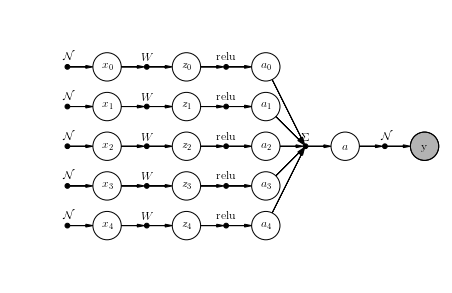

In [12]:
K = 5
experts = None
for k in range(K):
    expert = GP(size=N) @ V(id=f"x_{k}") @ LC(W) @ V(id=f"z_{k}") @ RC() @ V(id=f"a_{k}")
    experts = expert if experts is None else experts + expert
soft_committee = experts @ SumC(n_prev=K) @ V(id="a") @ GL(y=y)
soft_committee.to_model_dag().daft()